# Intro to PyTorch

Torch is a numerical computation library like Numpy but instead of arrays, it uses tensors. 

Tensors behave the same way as arrays but PyTorch has extra functionality under the hood which builds a computation graph as you perform calculations on the tensors and calculate gradients with one line of code.

PyTorch was made and is maintained by Facebook.

Below is a diagram of a computational graph. This one represents the computation of the loss (error) used in linear regression. Each node represents values (tensors usually), which are computed from all of, and only, the data nodes at the start of the incoming arcs (arrows). It displays the relationship between computed values, and crucially what data and operations they were computed from.

![title](images/NN1_computation_graph.JPG)

We could easily write functions in code to implement the mathematical functions that each node performs on its incoming data to compute it's values. Because we know what these functions are, we can also write functions to compute their rate of change (gradient) at any particular input values. That is, we can write functions that compute the derivative of the function.

# grad img

Thankfully, we don't have to write all of these functions and their derivatives that make up the layers of successive transformations in our model. That's what pytorch does.




In [18]:
import numpy as np   # for tensor math
import torch    # our deep learning framework
import torch.nn.functional as F    # contains functions like mean squared error that dont have parameters and can be called functionally
from random import shuffle

### Linear regression

In [2]:
def sample_linear_data(m=20):
    X = np.linspace(0, 1, 10)
    Y = 2*X + 0.7
    return X, Y #returns X (the input) which should have shape (m, 2) and Y (labels) which should have shape (m, 1)

In [3]:
X, Y = sample_linear_data()
print('X:',X, '\n')
print('Y:',Y, '\n')

X: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ] 

Y: [0.7        0.92222222 1.14444444 1.36666667 1.58888889 1.81111111
 2.03333333 2.25555556 2.47777778 2.7       ] 



## Making models in PyTorch

PyTorch makes it really easy for us to build complex models that can be improved via gradient based optimisation. It does this by providing a class named `torch.nn.Module`. Our model classes should inherit from this class because it does a few very useful things for us:

1. `torch.nn.Module` keeps track of all `torch.nn.Parameters` that are created within it. So when we add a linear layer to our model, the parameters (matrix of weights) in that layer will be added to a list of our model's parameters. We can retrieve all parameters of our model using its `parameters()` method. We will later pass this (`mymodel.parameters()`) to our optimiser when we tell it that *this* is what it should be optimising.


2. `torch.nn.Module` treats the `forward` method (function) of any child class specially by assigning it to the `__call__` method. That means that running `mymodel.forward(some_data)` is equal to `mymodel(some_data)`. 

In [4]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.linear_layer = torch.nn.Linear(1, 1)    # we want a linear transformation that maps from a scalar X to a scalar Y
     
    def forward(self, x):
        x = self.linear_layer(x)
        return x

## What data can a PyTorch model process?

### What type should it be?
Most models will have parameters that control what transformations are applied to the data they process. The parameters which are initialised in each layer of a PyTorch model are of type `torch.tensor`. Many of these transformations, like matrix multiplication between two tensors, won't work between data of different types.

We have created our fake data as type `numpy.ndarray`. So let's convert it into a torch tensor.

In [5]:
print(type((X)))
X = torch.tensor(X)
Y = torch.tensor(Y)

<class 'numpy.ndarray'>


### In what format does a layer expect to recieve an input?

PyTorch models expect to be fed data of shape `(batch_size, num_example_features)`. That is, it expects a of examples, and each example should also be a list. All of that is still required to be of type `torch tensor`. See more [here](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)

In [6]:
X = X.view(-1, 1)
print(X)
Y = Y.view(-1, 1)

data = zip(X, Y)

tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]], dtype=torch.float64)


### Specifically what kind of tensor?

On a computer, numbers can be stored with varying levels of precision. By default, the model parameters are stored as 32 bit floating point numbers (called type `Float`). But our fake datapoints that were transformed into a torch tensor are all 64 but floating point (called type `Double`). So we need to convert either the model parameters or the data into the other type so that they match and we can perform computations between them. 

64 bit floats are twice as accurate as, but take up twice the memory of 32 bit floats.

In [7]:
my_model = LinearModel().double()

## Differentiation in PyTorch and more about `torch.tensors`

In the linear regression notebook, we wrote our own functions to compute the rate of change (gradients) or our model with respect to its parameters. We then used these gradients to iteratively improve the model through gradient descent (making small updates to the parameters in the direction that decreases the error).

The gradient computing functions that we wrote in that notebook depended on the specific transformations (functions) that were applied on data passing through our model. If we changed the model, we would have to make sure that 

As illustrated in the computational graph, the relationship between our objective (loss) and the parameters which we want to optimise is defined by the layers of transformations that are used to compute the loss from these parameters.

**The chain rule** shows us that we can compute a derivative of a function by chaining together the derivatives of the functions that connect those variables.

# chain rule img

By looking at our computational graph, we can see which functions connect any variables by following the arcs backward from the furthest point forward. PyTorch has many useful functions that can be used as layers in our models. Because PyTorch expects us to be differentiating (it is an automatic differentiation library), it also has associated gradient computing functions for each of the layers it provides. So by evaluating these gradient functions of the functions that relate two variables that we care about and multiplying them together, we can compute the derivative of one with respect to another. 

We can do this by calling the `.backward()` method on any tensorThis happens without us having to write the gradient functions, or perform their multiplication.

### Computing the gradient automatically - `.backward()`


### `.grad_fn`
Every tensor that is created in PyTorch has an attribute called `grad_fn` (gradient function). This attribute specifies what operation was this value output by. Remember the nodes in our computation graph? Well the grad_fn is the function that was performed on the incoming values to compute the value at a particular node.

# grad_fn img

### `.requires_grad`
We don't need to track the gradients of our loss with respect to some variables (like our input data or our learning rate for example).
PyTorch tensors will only have a `grad_fn` if their **`requires_grad`** attribute is true.

Let's play around with `grad_fn` and `requires_grad` now.

### Where does a tenso's gradient get stored? `.grad`
Not only do torch tensors store their current values, but they can also store computed gradients.




In [8]:
x = torch.rand(1)
print(x.shape)
print('requires_grad:', x.requires_grad)
print('grad_fn:', x.grad_fn)
print('x grad:', x.grad)

w = torch.rand(1, requires_grad=True)    # use the keyword argument to track 
# w.requires_grad=True    # we could also have done this instead of using the keyword argument
print()
print('weight requires_grad:', w.requires_grad)
print('weight grad_fn:', w.grad_fn)
print('weight grad:', w.grad)

h = w*x
print()
print('hypothesis requires_grad:', h.requires_grad)
print('hypothesis grad_fn:', h.grad_fn)

h.backward()

print()
print('x.grad:', x.grad)
print('w.grad:', w.grad)


torch.Size([1])
requires_grad: False
grad_fn: None
x grad: None

weight requires_grad: True
weight grad_fn: None
weight grad: None

hypothesis requires_grad: True
hypothesis grad_fn: <MulBackward0 object at 0x7fa5cf681da0>

x.grad: None
w.grad: tensor([0.6551])


## Optimisation in PyTorch

As well as providing tensors and layers, PyTorch provides optimisers. This means that we don't have to write our own optimisers which again are likely to be slower and less efficient. We also don't have to stay up to date with  the latest state of the art optimisers. We don't even need to know how they work to be honest. We can just let Facebook do the hard work for us!

A module named `torch.optim` contains many classes that are templates for common optimisers. They include SGD, Adam, RMSProp, Ada and many more optimisers. Most of the time we should just use SGD or Adam.

### `.parameters()`
When we initialise our PyTorch optimisers, we need to tell it what it will be optimising. What should it be optimising? When we create our model that inherits from `torch.nn.Module`, PyTorch looks out for any layers that also inherit from `torch.nn.Module` (like our `Linear` layer). It knows that the weights of these layers are parameters of our model, and they are automatically added to the model's list of parameters (see more [here](https://pytorch.org/docs/stable/nn.html#torch.nn.Parameter)). We can get the parameters of our model at any point by using it's `.parameters()` method (thanks to the fact that the model inherited from `torch.nn.Module`).

Most optimisers also require an initial learning rate, so we should pass that in too.

### `.step()`
The optimisers that PyTorch provides all use the gradient of the loss (with respect to the parameters that they optimise) to compute how much they should update each weight and in what direction. They access this gradient by looking at the `.grad` attribute for all the parameters that they optimise, which is computed when we call `.backward` on any variable that these parameters affect. We can use the optimiser's `.step()` method  to actually perform the parameter updates - this is the ***learning*** in machine learning.

### `.zero_grad()`
Calling `.backward()` **does not reset** the existing parameter values of `.grad` for the tensore which gradients are computed for. Instead it **accumulates** them, adding to what was previously there. We may not want this, and we can use out optimiser's `.zero_grad()` method to reset the `.grad` values of the parameters which it's optimising back to zero.

## Let's combine all of that to train a simple linear model in PyTorch

Epoch: 0 	Loss: 0.03427802165094261
Epoch: 1 	Loss: 0.020497414338046714
Epoch: 2 	Loss: 0.0148282668315418
Epoch: 3 	Loss: 0.010735872505920778
Epoch: 4 	Loss: 0.007772946622934147
Epoch: 5 	Loss: 0.0056277400762725725
Epoch: 6 	Loss: 0.004074575563683276
Epoch: 7 	Loss: 0.0029500591354894605
Epoch: 8 	Loss: 0.0021358909086024534
Epoch: 9 	Loss: 0.0015464198390361045
learnt weight: Parameter containing:
tensor([[1.8799]], dtype=torch.float64, requires_grad=True) 	learnt bias: tensor([0.7653], dtype=torch.float64)


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

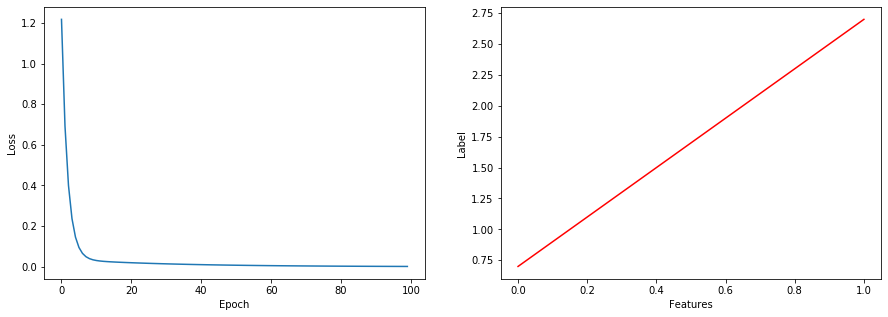

In [49]:
H = LinearModel()   # instantiate our model
H = H.double()
optimiser = torch.optim.SGD(H.parameters(), lr=0.1)    # use PyTorch's Stochastic Gradient Descent optimiser
L = F.mse_loss    # use a pytorch function that computes the mean squared error (mse)

epochs = 10
losses = []
for epoch in range(epochs):
    data = list(zip(X, Y))
    shuffle(data)
    for x, y in data:    # iterate through batches
        prediction = H(X)    #make a prediction using our model
        loss = L(prediction, Y)    # compute the loss
        loss.backward()    # differentiate the loss with respect to all variables that contribute to it in the computational graph and have requires_grad=True
        optimiser.step()    # take an optimisation step (update weights)
        optimiser.zero_grad()    # reset gradients to zero (otherwise they accumulate)
        losses.append(loss)
    print(f'Epoch: {epoch} \tLoss: {loss}')
        
# GET THE LEARNT PARAMETERS
w = H.linear_layer.weight.detach()    # detach removes the tensor from the graph so we can do numpy computation on it
b = H.linear_layer.bias.detach()
print('learnt weight:', w, '\tlearnt bias:', b)
    
# PLOT THE LOSS CURVE AND OUR HYPOTHESIS
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.plot(losses)

ax2 = fig.add_subplot(122)
ax2.set_ylabel('Label')
ax2.set_xlabel('Features')
ax2.plot(X, Y, c='r', label='ground truth')
ax2.plot(X, w*X+b, label='predictions')
ax2.legend()
plt.show()